## SVM with PCA as dimension reduction Project :: Object recognition

#### Data Description:
The data contains features extracted from the silhouette of vehicles in different angles. Four "Corgie" model vehicles were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400 cars. This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable.
#### Context:
The purpose is to classify a given silhouette as one of three types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.

#### 1. Data pre-processing – Perform all the necessary preprocessing on the data ready to be fed to an Unsupervised algorithm

In [56]:
import numpy as np # Linear Algebra
import pandas as pd # Data processing
import seaborn as sns # Data Visualization
from matplotlib import pyplot as plt # Data Visualization
#To enable plotting graphs in Jupyter notebook
%matplotlib inline
#importing the Encoding library
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats # Data computing
from scipy.stats import zscore# Data normalization

In [57]:
# Read the dataset
Dataset_Df = pd.read_csv('vehicle-1.csv', sep=',') 
Dataset_Df.head(5)

compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio class  
0             187.0            197   van  
1             189.0            199   van  
2             188.0            196   car  
3             199.0            207   van  
4             180.0            183   bus

In [58]:
# Checking shape, data type and missing value
Dataset_Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_gyration    844 non-null    float64
 13  scaled_radius_of_gyr

#### Inference:
* Data has 18 feature columns which is of numeric data type.
* Last column 'Class'  is the category column mentioning the vehicle label for each 846 rows of data.
* There are columns which has null values and needed treatment.

In [59]:
Dataset_Df['class'].unique() # Check unique values in target column

array(['van', 'car', 'bus'], dtype=object)

In [60]:
#Convert categorical column to numeric to help ease computation
Dataset_Df.replace({'class' : {'car': 0, 'bus': 1, 'van': 2}}, inplace = True)

In [61]:
#converting categorical column datatype to int datatype
Dataset_Df['class'] = Dataset_Df['class'].astype('int64')

In [62]:
# Get unique target class label and check data available for each class category
pd.DataFrame(Dataset_Df['class'].value_counts()).rename(index={ 0 : 'car', 1 : 'bus',2 : 'van'}).T

car  bus  van
class  429  218  199

In [63]:
Dataset_Df.isnull().sum().sort_values(ascending=False) # Null value check

radius_ratio                   6
skewness_about                 6
circularity                    5
scaled_radius_of_gyration.1    4
distance_circularity           4
scaled_variance                3
pr.axis_rectangularity         3
scaled_radius_of_gyration      2
scaled_variance.1              2
pr.axis_aspect_ratio           2
skewness_about.2               1
skewness_about.1               1
elongatedness                  1
scatter_ratio                  1
class                          0
max.length_rectangularity      0
max.length_aspect_ratio        0
hollows_ratio                  0
compactness                    0
dtype: int64

In [64]:
# Treatment of replacing the NaN values with respective column median for each class category
uniq_class = Dataset_Df['class'].unique()
for i in uniq_class:
    mask1 = (Dataset_Df['class'] == i)
    Dataset_Df.loc[mask1, 'compactness':'hollows_ratio'] = Dataset_Df.loc[mask1, 'compactness':'hollows_ratio'].apply(lambda x: x.fillna(x.median()),axis=0)

In [65]:
#Cross check any NaN/Null values presence
Dataset_Df[Dataset_Df.isnull().any(1)].shape[0]

0

#### Inference:
* We have 50% of data for car followed by ~25% of bus and ~25% of van. This shall induce bias in the training sets which needs to be addressed.
* No Null values present.

#### 2. Understanding the attributes - Find relationship between different attributes (Independent variables) and choose carefully which all attributes have to be a part of the analysis and why

In [66]:
#find minimum, maximum, average, standard deviation as well as quantile values with respect to each numeric column
Dataset_Df.describe().T

count        mean         std    min     25%  \
compactness                  846.0   93.678487    8.234474   73.0   87.00   
circularity                  846.0   44.826241    6.134340   33.0   40.00   
distance_circularity         846.0   82.066194   15.754263   40.0   70.00   
radius_ratio                 846.0  168.916076   33.427561  104.0  141.00   
pr.axis_aspect_ratio         846.0   61.680851    7.882557   47.0   57.00   
max.length_aspect_ratio      846.0    8.567376    4.601217    2.0    7.00   
scatter_ratio                846.0  168.920804   33.199802  112.0  147.00   
elongatedness                846.0   40.927896    7.813401   26.0   33.00   
pr.axis_rectangularity       846.0   20.579196    2.590879   17.0   19.00   
max.length_rectangularity    846.0  147.998818   14.515652  118.0  137.00   
scaled_variance              846.0  188.643026   31.378020  130.0  167.00   
scaled_variance.1            846.0  439.665485  176.492876  184.0  318.25   
scaled_radius_of_gyration    846.0  174.712766   32.546284  109.0  149.00   
scaled_radius_of_gyration.1  846.0   72.443262    7.470873   59.0   67.00   
skewness_about               846.0    6.356974    4.904073    0.0    2.00   
skewness_about.1             846.0   12.604019    8.930921    0.0    5.00   
skewness_about.2             846.0  188.919622    6.152167  176.0  184.00   
hollows_ratio                846.0  195.632388    7.438797  181.0  190.25   
class                        846.0    0.728132    0.818044    0.0    0.00   

                                50%     75%     max  
compactness                   93.00  100.00   119.0  
circularity                   44.00   49.00    59.0  
distance_circularity          80.00   98.00   112.0  
radius_ratio                 167.25  195.00   333.0  
pr.axis_aspect_ratio          61.00   65.00   138.0  
max.length_aspect_ratio        8.00   10.00    55.0  
scatter_ratio                157.00  198.00   265.0  
elongatedness                 43.00   46.00    61.0  
pr.axis_rectangularity        20.00   23.00    29.0  
max.length_rectangularity    146.00  159.00   188.0  
scaled_variance              179.00  217.00   320.0  
scaled_variance.1            364.00  586.75  1018.0  
scaled_radius_of_gyration    174.00  198.00   268.0  
scaled_radius_of_gyration.1   71.00   75.00   135.0  
skewness_about                 6.00    9.00    22.0  
skewness_about.1              11.00   19.00    41.0  
skewness_about.2             188.00  193.00   206.0  
hollows_ratio                197.00  201.00   211.0  
class                          0.00    1.00     2.0

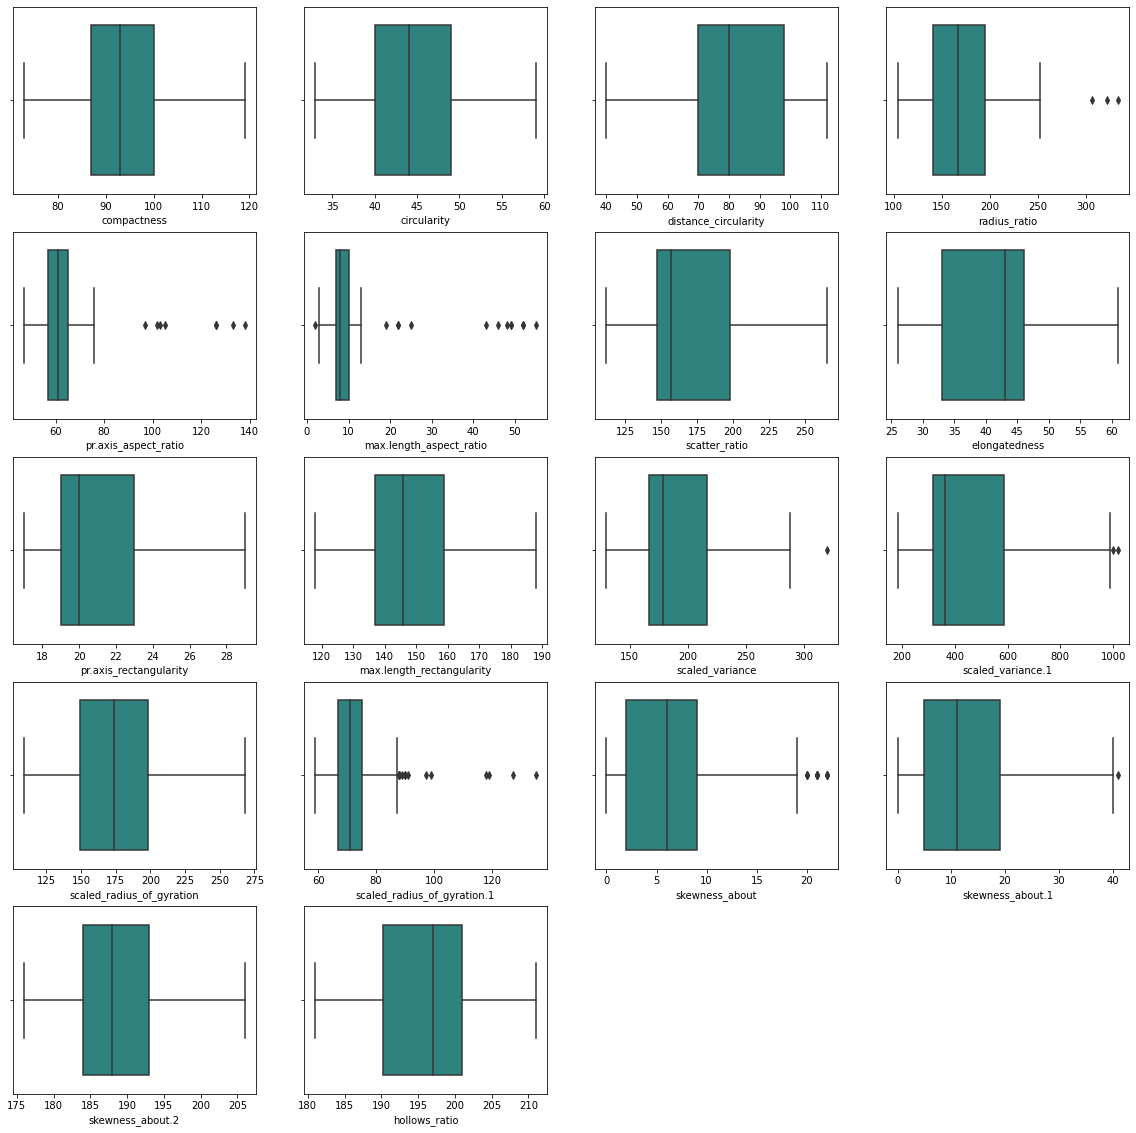

In [99]:
#Visual check on distribution,skewness and outliers for each attributes
plt.figure(figsize=(20,20))
k=1
for col in Dataset_Df.columns[0:18]: # iterating columns except dependent column
    plt.subplot(5,4,k)
    sns.boxplot(y=Dataset_Df[col],orient='h',palette='viridis')
    k=k+1
plt.show()

#### Inference:
* The attributes have different scales. We need to use data normalization functions before using PCA as its output is influenced by the scales of the attributes.
* There are outliers for following columns on higher scales: radius_ratio, max_length_aspect_ratio, pr.axis_aspect_ratio, scaled_variance, scaled_variance.1, scaled_radius_of_gyration.1, skewness_about and skewness_about.1. However, we need to check if these outliers are due to misclassification only then we choose to drop. Else these outliers could be natural and legitimate observations then we choose to keep.
* max.length_aspect_ratio is highly right skewed with presence of high outliers.
* pr.axis_aspect_ratio and scaled_radius_of_gyration.1 is having normal distribution with outliers.

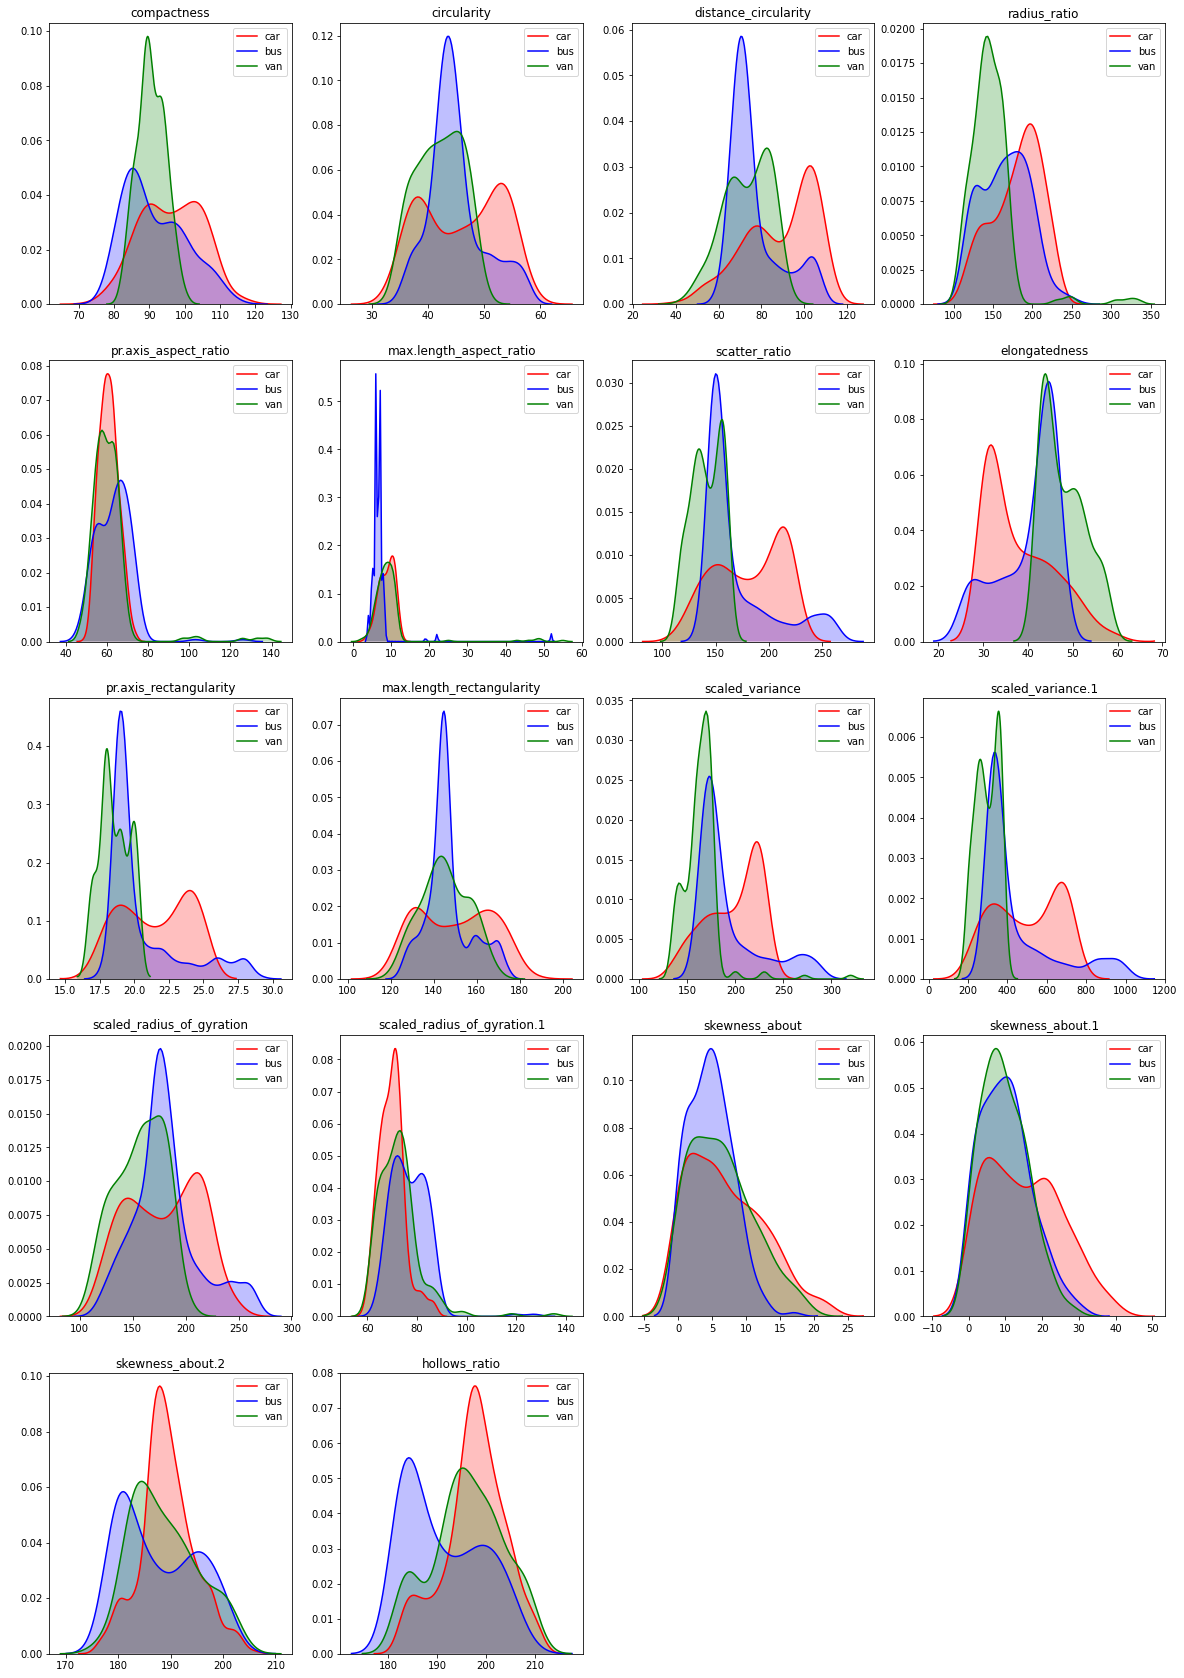

In [101]:
# kde plots to show the distribution of the all the variables with respect to dependent variable
k=1
plt.figure(figsize=(20,30))
for col in Dataset_Df.columns[0:18]:
    plt.subplot(5,4,k)
    sns.kdeplot(Dataset_Df[Dataset_Df['class']== 0][col],color='red',label='car',shade=True)
    sns.kdeplot(Dataset_Df[Dataset_Df['class']== 1][col],color='blue',label='bus',shade=True)
    sns.kdeplot(Dataset_Df[Dataset_Df['class']== 2][col],color='green',label='van',shade=True)
    plt.title(col)
    k=k+1

#### Inference:
* None of the attributes alone will be able to classify the objects significantly as the distributions are overlapping.
* Consider the hollows ratio, car and bus can be seperately classified with much accuracy. However, will not be able to classify car or van using this attribute. Also, the distributions has two humps indicating bimodal data or presence of two groups within the same target variable which is overlapping.
* As earlier mentioned max.length_aspect_ratio is highly right skewed with presence of high outliers. Instead of dropping and losing information we shall use scaling function to be useful for model prediction.
* pr.axis_aspect_ratio and scaled_radius_of_gyration.1 is having normal distribution with outliers which can be due to misclassification. Hence these outlier datapoints shall be removed before spliting the data for SVM.

In [102]:
#Treating skewness of max_length_aspect_ratio column using log transformation
Dataset_Df['log_max.length_aspect_ratio'] = np.log(Dataset_Df['max.length_aspect_ratio'])
Dataset_Df =  Dataset_Df.drop(['max.length_aspect_ratio'], axis=1) # Keeping log transformed of the respective column

In [103]:
#Treating outliers pr.axis_aspect_ratio, scaled_radius_of_gyration.1
#from scipy import stats
Dataset_Df['Scaled_pr.axis_aspect_ratio'] = np.abs(stats.zscore(Dataset_Df['pr.axis_aspect_ratio']))
Dataset_Df=Dataset_Df[Dataset_Df['Scaled_pr.axis_aspect_ratio']<3]
Dataset_Df.drop('Scaled_pr.axis_aspect_ratio',axis =1, inplace = True)

Dataset_Df['Scaled_scaled_radius_of_gyration.1'] = np.abs(stats.zscore(Dataset_Df['scaled_radius_of_gyration.1']))
Dataset_Df=Dataset_Df[Dataset_Df['Scaled_scaled_radius_of_gyration.1']<3]
Dataset_Df.drop('Scaled_scaled_radius_of_gyration.1',axis =1, inplace = True)

Dataset_Df['Scaled_log_max.length_aspect_ratio'] = np.abs(stats.zscore(Dataset_Df['log_max.length_aspect_ratio']))
Dataset_Df=Dataset_Df[Dataset_Df['Scaled_log_max.length_aspect_ratio']<3]
Dataset_Df.drop('Scaled_log_max.length_aspect_ratio',axis =1, inplace = True)

Dataset_Df.shape

(829, 19)

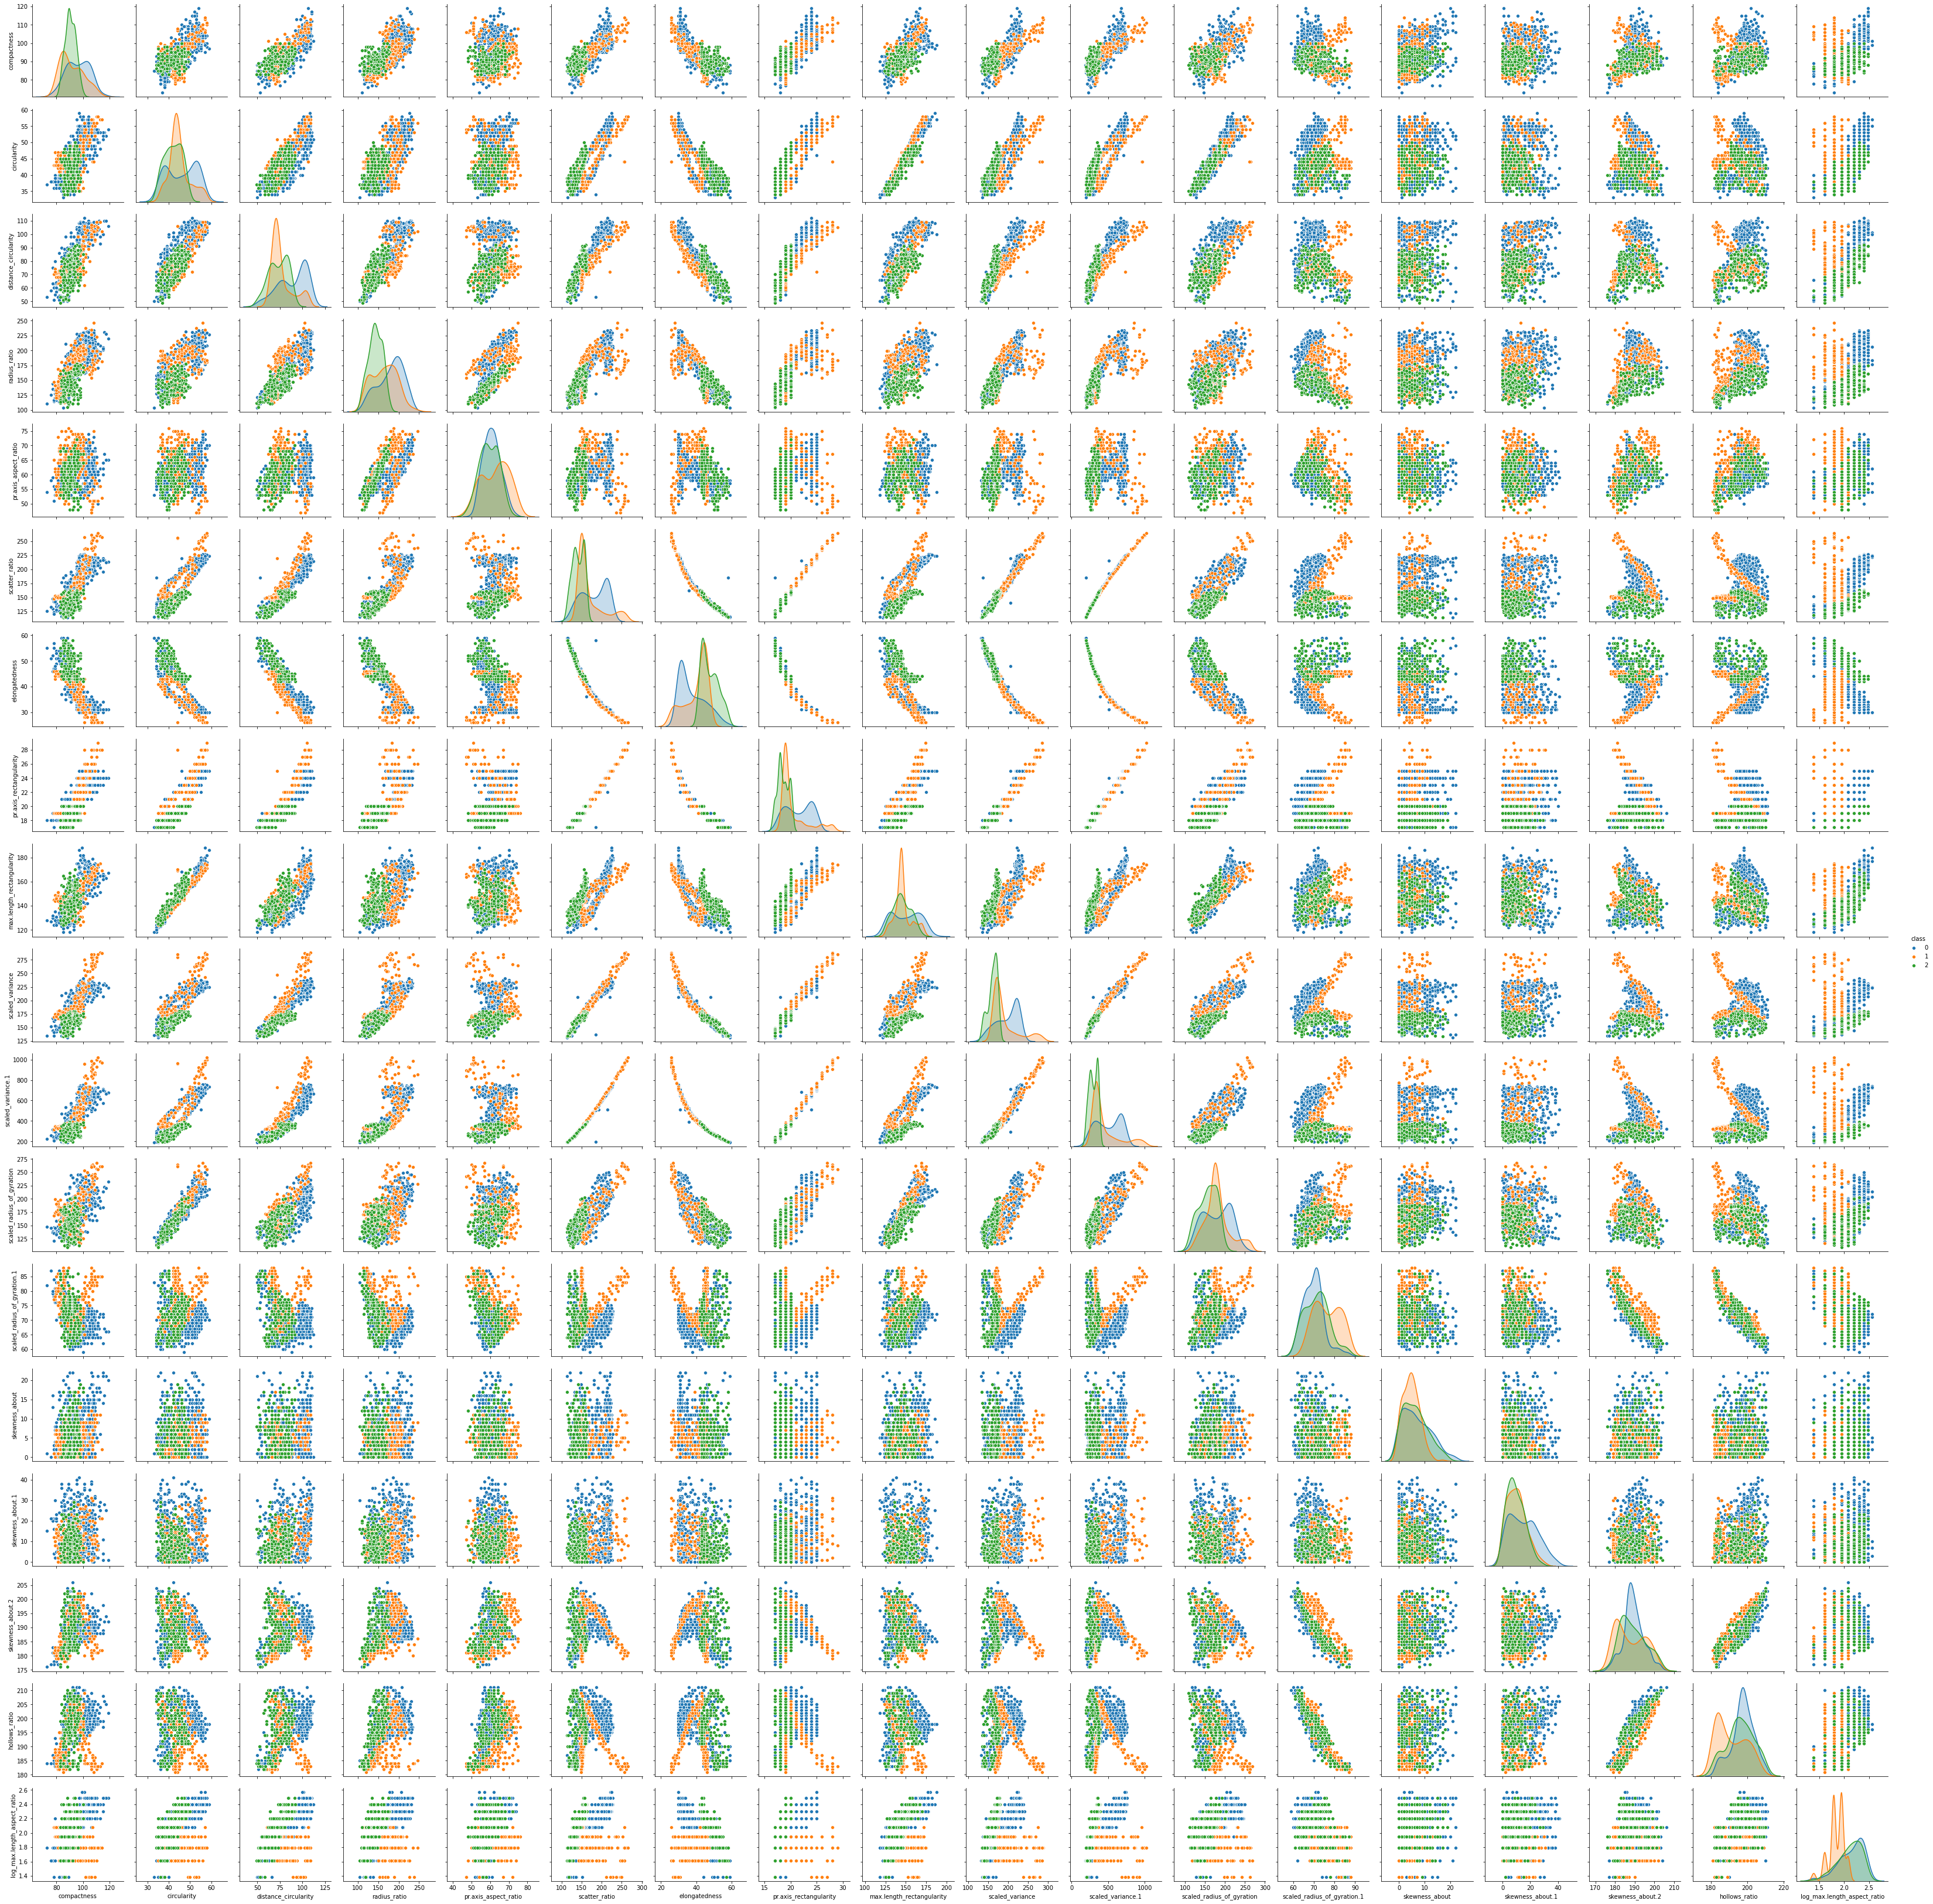

In [104]:
# To check relationship between the independent variables(attributes)
sns.pairplot(Dataset_Df,diag_kind='kde',hue='class')

#### Inference:
* From the pair plots, we observe multicollinearity in many of the attributes like 'compactness and circularity - positive relation', 'compactness and elongatedness - negative relation' etc. and questions the required independent characteristics.
* We can drop the attributes which are highly correlated with each other by setting threshold and hypothesis test can be implemented on all these variables by checking p-value of those and variables can be removed which are having p-value more than 0.05. However, we will lose information by dropping the entire column.
* The best approach is to use PCA inorder to check multicolinearity and able to reduce the attributes without losing much information from the data.
* However, we will check the correlation with class label and drop the attributes that has low correlation in order to examine the performance of model

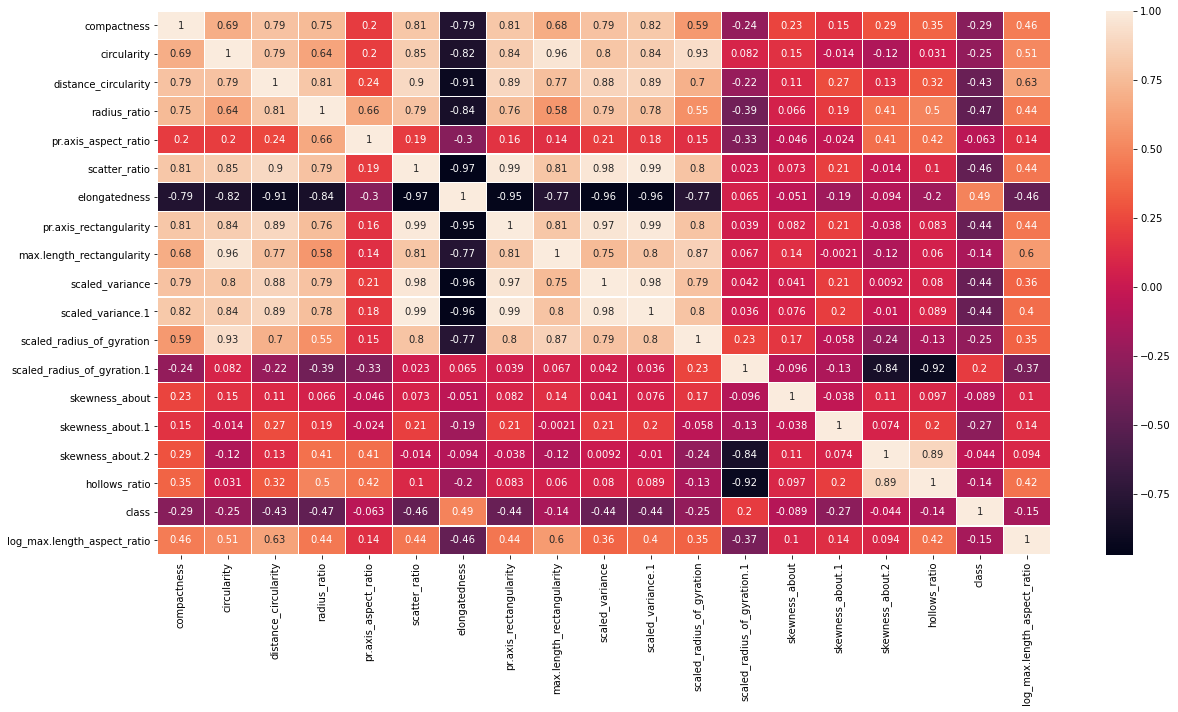

In [105]:
# Check the correlation in attributes using heatmap and validate the above inference.
fig= plt.subplots(figsize=(20, 10))
sns.heatmap(Dataset_Df.corr(),annot=True, linewidth = 0.2)

In [106]:
# correlation coefficient values in each attributes wrto to class.
correlation_values=Dataset_Df.corr()['class']
correlation_values.abs().sort_values(ascending=False)

class                          1.000000
elongatedness                  0.485636
radius_ratio                   0.472626
scatter_ratio                  0.462722
pr.axis_rectangularity         0.443378
scaled_variance                0.443212
scaled_variance.1              0.442043
distance_circularity           0.434059
compactness                    0.293804
skewness_about.1               0.272287
circularity                    0.251968
scaled_radius_of_gyration      0.249378
scaled_radius_of_gyration.1    0.195546
log_max.length_aspect_ratio    0.154380
max.length_rectangularity      0.142150
hollows_ratio                  0.139644
skewness_about                 0.088921
pr.axis_aspect_ratio           0.063050
skewness_about.2               0.044383
Name: class, dtype: float64

#### Inference:
* elogatedness is correlated to class label (~0.48). Also it is highly correlated (> |0.8| ) with other attributes -scaled_variance, scaled_variance.1, scatter_ratio, pr.axis_rectangularity, distance_circularity, radius_ratio, circularity. We can keep elogatedness and remove the remaining attributes.
* hollows_ratio, skewness_about.2 and scaled_radius_of_gyration.1' are correlated ( >|0.8|). We will discard hollows_ratio and skewness_about.2 as scaled_radius_of_gyration.1 is better attribute to predict class label.
* scaled_radius_of_gyration and max.length_rectangularity are correlated. We will discard max.length_rectangularity.

In [107]:
#Creating new dataframe by discarding redundant features based on correlation and check SVM on this dataframe too.
Reduced_Df = Dataset_Df.drop(['scaled_variance', 'scaled_variance.1', 'scatter_ratio', 'pr.axis_rectangularity', 'distance_circularity', 'radius_ratio', 'circularity','skewness_about.2','hollows_ratio','max.length_rectangularity'], axis = 1)
print('Based on above inference we now keep',Reduced_Df.shape[1]-1,'attributes and remaining attributes not considered')
print('Reduced dataset columns are:\n', pd.DataFrame(Reduced_Df.columns).values )

Based on above inference we now keep 8 attributes and remaining attributes not considered
Reduced dataset columns are:
 [['compactness']
 ['pr.axis_aspect_ratio']
 ['elongatedness']
 ['scaled_radius_of_gyration']
 ['scaled_radius_of_gyration.1']
 ['skewness_about']
 ['skewness_about.1']
 ['class']
 ['log_max.length_aspect_ratio']]


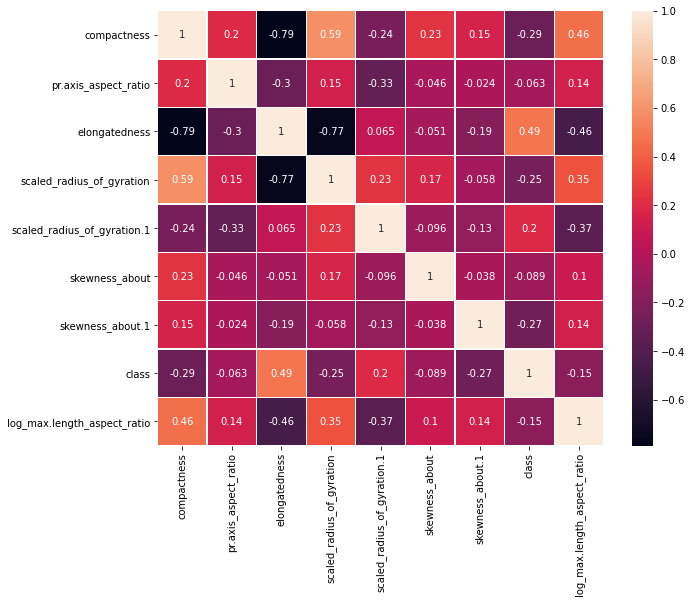

In [110]:
fig= plt.subplots(figsize=(10, 8))
sns.heatmap(Reduced_Df.corr(),annot=True, linewidth = 0.2)

#### 3. Split the data into train and test (Suggestion: specify “random state” if you are using train_test_split from Sklearn) 

In [112]:
# We create split datasets for both - data with all 18 attribute and data with 9 attribute
X = Dataset_Df.drop('class', axis = 1) # taking all attributes
y = Dataset_Df["class"]                   # target variable
Xr = Reduced_Df.drop('class', axis = 1) # keeping relevant attributes based on correlation
yr = Reduced_Df["class"]                   # target variable

# splitting data into train and test datasets.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=1)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.20,random_state=1)

# As mentioned earlier we have attributes with different scales.
# hence we scaling function on the data features before using to create the model and compare.
from sklearn.preprocessing import StandardScaler

sc=StandardScaler()
scaledX_train = sc.fit_transform(X_train)
scaledX_test = sc.transform(X_test)

scaledXr_train = sc.fit_transform(Xr_train)
scaledXr_test = sc.transform(Xr_test)

print('Considering all attributes dataset shape:')
print('Training Data set (Attributes):', X_train.shape)
print('Training Data set (Target Label):', y_train.shape)
print('Test Data set (Attributes):', X_test.shape)
print('Test Data set (Target Label):', y_test.shape)

print('\nWith limited attributes (8) dataset shape:')
print('Training Data set (Attributes):', Xr_train.shape)
print('Training Data set (Target Label):', yr_train.shape)
print('Test Data set (Attributes):', Xr_test.shape)
print('Test Data set (Target Label):', yr_test.shape)

Considering all attributes dataset shape:
Training Data set (Attributes): (663, 18)
Training Data set (Target Label): (663,)
Test Data set (Attributes): (166, 18)
Test Data set (Target Label): (166,)

With limited attributes (8) dataset shape:
Training Data set (Attributes): (663, 8)
Training Data set (Target Label): (663,)
Test Data set (Attributes): (166, 8)
Test Data set (Target Label): (166,)


#### 4. Train a Support vector machine using the train set and get the accuracy on the test set

In [113]:
from sklearn.svm import SVC      
# instantiating the model using support vector classifier with default parameters (rbf kernel)
svm = SVC() 
svm.fit(scaledX_train, y_train) # fitting the model using training dataset - 18 attributes
predicted = svm.predict(scaledX_test) #Fetching the predicted target variable for test dataset

# instantiating the model using support vector classifier
svm_r = SVC() 
svm_r.fit(scaledXr_train, yr_train) # fitting the model using training dataset - 8 attributes
predicted_r = svm_r.predict(scaledXr_test) #Fetching the predicted target variable for test dataset

In [116]:
from tabulate import tabulate
data = [['All 18 Attributes', svm.score(scaledX_train,y_train)*100, svm.score(scaledX_test,y_test)*100],
        ['With 8 attributes', svm_r.score(scaledXr_train,yr_train)*100, svm_r.score(scaledXr_test,yr_test)*100]]
print ( tabulate(data, headers=["SVM Model", "Training_Score", "Test_Score"]))

SVM Model            Training_Score    Test_Score
-----------------  ----------------  ------------
All 18 Attributes           98.0392       95.7831
With 8 attributes           96.5309       94.5783


In [130]:
#Classification report for both models
from sklearn.metrics import confusion_matrix,classification_report

print('Classification Report for SVM model using all attributes:\n', classification_report(y_test,predicted))
print('\nClassification Report for SVM model using 8 attributes:\n', classification_report(yr_test,predicted_r))

Classification Report for SVM model using all attributes:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96        90
           1       0.97      1.00      0.99        35
           2       0.95      0.90      0.92        41

    accuracy                           0.96       166
   macro avg       0.96      0.96      0.96       166
weighted avg       0.96      0.96      0.96       166


Classification Report for SVM model using 8 attributes:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95        90
           1       0.92      1.00      0.96        35
           2       0.95      0.90      0.92        41

    accuracy                           0.95       166
   macro avg       0.94      0.95      0.94       166
weighted avg       0.95      0.95      0.95       166



<function matplotlib.pyplot.show(*args, **kw)>

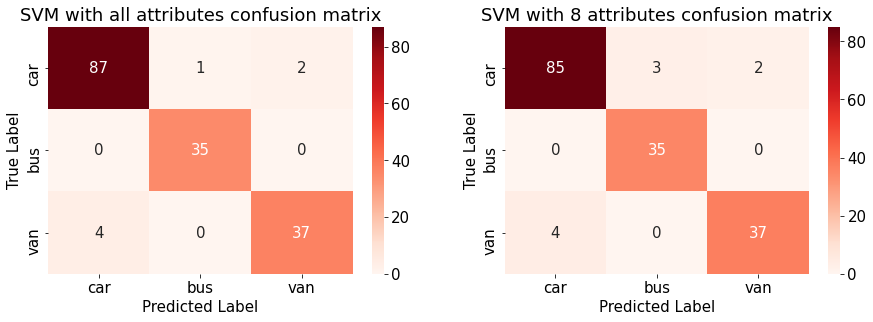

In [131]:
# Confusion Matrix for both model
cm_svm = confusion_matrix(y_test,predicted) # crosstab for actual and predicted class
cm_svmr = confusion_matrix(yr_test,predicted_r)

class_label = ["car", "bus" ,"van"]
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 15})
plt.subplot(2,2,1)
df_svm = pd.DataFrame(cm_svm, index = class_label, columns = class_label)
sns.heatmap(df_svm, annot = True, fmt = "d", cmap="Reds")
plt.title("SVM with all attributes confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.subplot(2,2,2)
df_svmr = pd.DataFrame(cm_svmr, index = class_label, columns = class_label)
sns.heatmap(df_svmr, annot = True, fmt = "d", cmap="Reds")
plt.title("SVM with 8 attributes confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show

In [132]:
#Lets see the cross validation score for both model

#scaling entire attribute data for crossvalidation
scaledX = X.apply(zscore) 
scaledXr = Xr.apply(zscore) 

All Attributes:: 97.224508 (1.793216)
8 Attributes:: 93.604173 (1.634154)


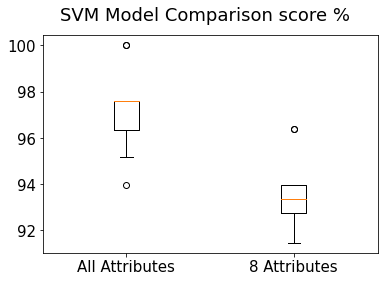

In [139]:
#Cross Validation performance of both SVM models
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#Cross Validation
kfold = KFold(n_splits = 10, random_state = 1) # initialising kfold object
scores_svm = cross_val_score(svm, scaledX, y, cv = kfold)*100
scores_svmr = cross_val_score(svm_r, scaledXr, y, cv = kfold)*100

print('%s: %f (%f)' %('All Attributes:',scores_svm.mean(), scores_svm.std()))
print('%s: %f (%f)' %('8 Attributes:',scores_svmr.mean(), scores_svmr.std()))

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('SVM Model Comparison score %')
ax = fig.add_subplot(111)
plt.boxplot([scores_svm ,scores_svmr])
ax.set_xticklabels(['All Attributes', '8 Attributes'])
plt.show()

In [140]:
data = [['All_Attributes', svm.score(scaledX_train,y_train)*100, svm.score(scaledX_test,y_test)*100, scores_svm.mean()*100],
        ['8 attributes', svm_r.score(scaledXr_train,yr_train)*100, svm_r.score(scaledXr_test,yr_test)*100, scores_svmr.mean()*100]
       ]
print ('\033[1m', tabulate(data, headers=["SVM Model", "Training_Score", "Test_Score" , "CrossValidation_Mean_Score"]))

 SVM Model         Training_Score    Test_Score    CrossValidation_Mean_Score
--------------  ----------------  ------------  ----------------------------
All_Attributes           98.0392       95.7831                       9722.45
8 attributes             96.5309       94.5783                       9360.42


#### Inference:
* Scores degraded with SVM on dataset with reduced attributes.
* Van is getting misclassified as car in some cases. In some case car is getting missclassified as bus and van.
* Crossvalidation shows further degradation in classification using dataset with reduced attributes.
* We observe that removing attributes also losses out information that would have help in improving score.
* We can use PCA in order to reduce attributes without losing information.

#### 5. Use PCA from Scikit learn, extract Principal Components that capture about 95% of the variance in the data.

In [146]:
# Using PCA from scikit learn
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scaledX_train) #using scaledX_train for PCA

PCA()

In [147]:
# Eigen Vectors
pd.DataFrame(pca.components_)

0         1         2         3         4         5         6  \
0   0.272956  0.287823  0.303147  0.271837  0.095247  0.312036 -0.309231   
1  -0.087897  0.125749 -0.050843 -0.209338 -0.263071  0.069742 -0.008822   
2  -0.043174 -0.213249  0.052727  0.080914 -0.028594  0.115149 -0.110823   
3  -0.144019  0.062221 -0.104449  0.238860  0.616514 -0.009634 -0.060418   
4   0.184467 -0.123270 -0.088157  0.095758  0.021195  0.074119 -0.056303   
5   0.237852 -0.014225 -0.021974 -0.164361 -0.589316  0.070911 -0.051602   
6  -0.156278  0.398933 -0.195176 -0.165063 -0.056317 -0.105888  0.132677   
7   0.786176  0.030810 -0.259430 -0.030868  0.190553 -0.084475  0.227152   
8   0.303964  0.062037  0.294348  0.159152 -0.010919 -0.130374  0.291752   
9  -0.185540  0.198918 -0.051121  0.030395  0.041236  0.125530  0.095843   
10 -0.017762 -0.062953 -0.794287  0.136551 -0.039582  0.148071  0.018844   
11 -0.000901 -0.152957  0.180861 -0.242827  0.102397  0.090512  0.245654   
12 -0.124121 -0.245133  0.113479 -0.224533  0.156901  0.008786  0.600525   
13  0.138740 -0.167334 -0.018481 -0.713257  0.318488  0.072688 -0.462359   
14  0.006934 -0.365053 -0.098095  0.023371  0.002273 -0.116017  0.074882   
15 -0.014625 -0.612667  0.046102  0.300092 -0.115492  0.015347 -0.172626   
16  0.003766 -0.094682  0.017605 -0.004757  0.006437  0.383230  0.061486   
17  0.000115  0.006946 -0.006403 -0.025676  0.016729  0.791678  0.211503   

           7         8         9        10        11        12        13  \
0   0.309285  0.277847  0.303942  0.309041  0.267071 -0.024785  0.053146   
1   0.080422  0.114004  0.070012  0.076182  0.197519  0.504804 -0.050345   
2   0.110668 -0.240690  0.165668  0.122223 -0.193377  0.071582 -0.540401   
3  -0.034151 -0.014270  0.035306 -0.004330  0.100047  0.098578 -0.441818   
4   0.075065 -0.239393  0.142515  0.113979 -0.003979  0.091719  0.555400   
5   0.077995  0.009004  0.097666  0.100718 -0.057725 -0.166355 -0.404764   
6  -0.097671  0.389042 -0.105152 -0.080422  0.431042 -0.053947 -0.090916   
7  -0.023807  0.204599 -0.141897 -0.043345 -0.200128  0.288403 -0.114196   
8  -0.072387 -0.172354 -0.086006 -0.083074  0.269955 -0.553459 -0.084048   
9   0.228481  0.425446 -0.141432  0.173323 -0.638858 -0.291075  0.070494   
10  0.236359 -0.178524  0.019775  0.207252  0.224211 -0.268509  0.011810   
11  0.277928 -0.116518 -0.189701  0.189350  0.139607  0.212520 -0.003352   
12  0.282131  0.098470  0.198088  0.270818  0.101557 -0.064692 -0.009101   
13  0.031804  0.052533 -0.035573 -0.030709  0.063746 -0.301317  0.005425   
14 -0.281575  0.388091  0.678906 -0.124268 -0.001717 -0.062158  0.035678   
15  0.164952  0.423151 -0.455986 -0.101374  0.215876  0.012990 -0.014290   
16 -0.696289  0.049033 -0.197358  0.558454  0.035172 -0.013116 -0.001871   
17 -0.012707 -0.019361  0.030258 -0.569761  0.007936 -0.007736 -0.004206   

          14        15        16        17  
0   0.063448  0.025163  0.069215  0.172737  
1  -0.093828 -0.492832 -0.507001 -0.143607  
2   0.636765 -0.009333 -0.034850 -0.251174  
3  -0.468838  0.050027 -0.073953 -0.279722  
4  -0.025275  0.226091 -0.088226 -0.672339  
5  -0.471196  0.274503  0.107212 -0.176586  
6   0.338545  0.256701  0.184372 -0.359458  
7   0.110730  0.023762 -0.027731  0.058071  
8   0.026547 -0.399506 -0.217588 -0.215398  
9  -0.028518 -0.229372 -0.041618 -0.244097  
10  0.023934 -0.190467  0.032331  0.175650  
11 -0.092838 -0.329776  0.663982 -0.142600  
12  0.000377  0.358523 -0.328881  0.150754  
13  0.030374 -0.048280 -0.132578 -0.038526  
14 -0.024808 -0.263406  0.223964 -0.076775  
15  0.002785  0.049601 -0.100199 -0.070158  
16  0.006091 -0.000643 -0.020635  0.009069  
17 -0.007797  0.031688 -0.008708 -0.011155

In [148]:
# Eigen Values
pd.DataFrame(pca.explained_variance_)

0
0   9.744107
1   3.472054
2   1.226440
3   1.128703
4   0.881368
5   0.660445
6   0.313100
7   0.217159
8   0.109789
9   0.078227
10  0.056884
11  0.044020
12  0.028461
13  0.025234
14  0.018519
15  0.015893
16  0.006388
17  0.000398

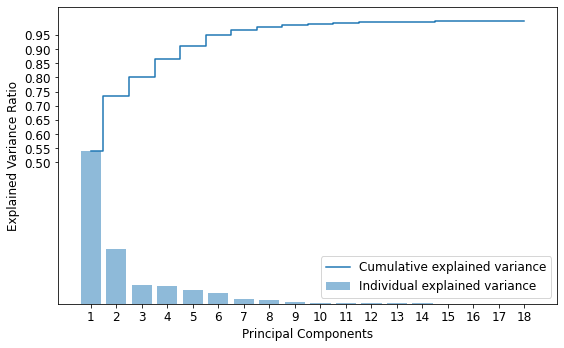

In [144]:
# Ploting 
plt.figure(figsize=(8 , 5))
plt.rcParams.update({'font.size': 12})
plt.bar(range(1, 19), pca.explained_variance_ratio_, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, 19), np.cumsum(pca.explained_variance_ratio_), where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.yticks(np.arange(0.5, 1, 0.05))
plt.xticks(np.arange(1, 19, 1))
plt.tight_layout()
plt.show()

In [145]:
for i in range(1, 19):
    total = (pca.explained_variance_ratio_[:i]*100).sum().round(1)
    print('Cummulative Variance % explained by Principle Component', i ,'is:', total)
    if (total < 96.00): c = i; cvar = total
print('\nWith',c, 'principle components we can have ',cvar,'% of the variance in the data captured.')

Cummulative Variance % explained by Principle Component 1 is: 54.1
Cummulative Variance % explained by Principle Component 2 is: 73.3
Cummulative Variance % explained by Principle Component 3 is: 80.1
Cummulative Variance % explained by Principle Component 4 is: 86.4
Cummulative Variance % explained by Principle Component 5 is: 91.3
Cummulative Variance % explained by Principle Component 6 is: 94.9
Cummulative Variance % explained by Principle Component 7 is: 96.7
Cummulative Variance % explained by Principle Component 8 is: 97.9
Cummulative Variance % explained by Principle Component 9 is: 98.5
Cummulative Variance % explained by Principle Component 10 is: 98.9
Cummulative Variance % explained by Principle Component 11 is: 99.2
Cummulative Variance % explained by Principle Component 12 is: 99.5
Cummulative Variance % explained by Principle Component 13 is: 99.6
Cummulative Variance % explained by Principle Component 14 is: 99.8
Cummulative Variance % explained by Principle Component 1

#### Inference:
* To capture 95% of variance atleast 7 PCA components needs to be considered.

#### 6. Train a Support vector machine using the Principal Components and get the accuracy on the test set

In [45]:
#Using PCA as dimensionality reduction we are generating 7 PCA components that will capture 95% of the variance in the data
pca2 = PCA(n_components = 7) 
pca2.fit(scaledX_train)

PCA(n_components=7)

In [149]:
#transforming the impute scaled raw data which is in 18 dimensions into 7 new dimensions with pca
pca_transformed =  pca2.transform(scaledX)
pca_transformed.shape

(829, 7)

In [150]:
pd.DataFrame(pca_transformed).T #new data with 7 attribute carrying 95% information captured of original data 

0         1         2         3         4         5         6    \
0  0.502996 -1.568245  3.894743 -1.670412  5.478568 -0.893825 -2.073101   
1 -0.717284 -0.343659  0.076846 -2.994533  4.592190 -2.186370 -1.506346   
2 -0.531652 -0.418937 -1.137791 -0.446892  1.280991 -1.570501 -1.031558   
3  0.818080 -1.213540 -0.000687 -0.216421 -0.382958  0.661024  0.979778   
4 -1.075319 -0.376242  0.698159 -0.504199  1.659719  1.768356 -1.063485   
5 -1.614148 -0.046229 -0.780110  0.545609  2.038742  0.524043  0.312846   
6  0.334148 -0.185472 -0.772737 -0.085154 -0.630099  0.435904  0.344038   

        7         8         9    ...       819       820       821       822  \
0 -4.520403  1.230311 -3.440175  ... -2.187328 -0.381116 -1.198939 -1.909672   
1 -3.124965 -2.098793 -1.952340  ...  0.389503 -0.865979 -0.325162 -1.916324   
2  0.612917  0.489968  0.207996  ... -0.272960 -1.720452  0.697026 -1.571790   
3 -0.040527 -0.284966  0.002820  ... -0.035361 -0.107805 -1.189763  0.377368   
4 -0.294111 -0.910154 -1.008686  ... -0.984169  0.538271 -1.532303 -0.056043   
5  0.763610  0.494639  0.482535  ...  0.206491  0.444187  0.083135  0.119761   
6  0.347177 -0.789151 -0.474060  ...  0.931018  0.122163  0.374341  0.647840   

        823       824       825       826       827       828  
0 -3.810003 -0.403744 -0.158221  4.983678 -3.370155 -5.047546  
1 -3.296579 -0.634916 -0.186170 -0.276837 -0.965676  0.652320  
2  1.620082  1.466188  0.329998 -0.531192  1.816123  1.295940  
3 -1.771820 -0.408893  0.252999  1.107637 -0.583059 -0.326543  
4  0.385786  0.359078 -2.104630 -1.162556 -0.631446  0.065657  
5  0.640980 -1.110713 -1.053071  0.470787  0.008682  0.353603  
6  0.435108 -0.900816  0.433376 -0.766800  0.146257  0.440305  

[7 rows x 829 columns]

In [151]:
# split the transformed pca data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_transformed, y, test_size = 0.20, random_state = 1)

# Shape of new train and test data
print('*** Transformed data using pca ***')
print('Shape of X_train:',X_train_pca.shape)
print('Shape of y_train:',y_train_pca.shape)
print('Shape of X_test:',X_test_pca.shape)
print('Shape of y_test:',y_test_pca.shape)

*** Transformed data using pca ***
Shape of X_train: (663, 7)
Shape of y_train: (663,)
Shape of X_test: (166, 7)
Shape of y_test: (166,)


In [152]:
# instantiating the model using support vector classifier with default parameters (rbf kernel)
svm_pca = SVC() 
svm_pca.fit(X_train_pca, y_train_pca) # fitting the model using training dataset
predicted_pca = svm_pca.predict(X_test_pca) #Fetching the predicted target variable for test dataset

In [153]:
print('Classification Report for SVM model using all attributes:\n', classification_report(y_test_pca,predicted_pca))

Classification Report for SVM model using all attributes:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96        90
           1       0.97      1.00      0.99        35
           2       0.90      0.93      0.92        41

    accuracy                           0.95       166
   macro avg       0.95      0.96      0.95       166
weighted avg       0.95      0.95      0.95       166



<function matplotlib.pyplot.show(*args, **kw)>

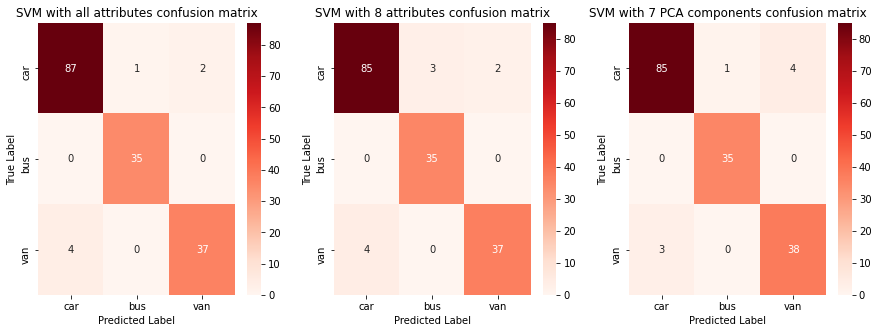

In [164]:
# Confusion Matrix for both model
cm_svm = confusion_matrix(y_test,predicted) # crosstab for actual and predicted class
cm_svmr = confusion_matrix(yr_test,predicted_r)
cm_svm_pca = confusion_matrix(y_test_pca,predicted_pca)

class_label = ["car", "bus" ,"van"]
plt.figure(figsize=(15,5))
plt.rcParams.update({'font.size': 10})
plt.subplot(1,3,1)
df_svm = pd.DataFrame(cm_svm, index = class_label, columns = class_label)
sns.heatmap(df_svm, annot = True, fmt = "d", cmap="Reds")
plt.title("SVM with all attributes confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.subplot(1,3,2)
df_svmr = pd.DataFrame(cm_svmr, index = class_label, columns = class_label)
sns.heatmap(df_svmr, annot = True, fmt = "d", cmap="Reds")
plt.title("SVM with 8 attributes confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.ylabel("True Label")
plt.subplot(1,3,3)
df_svm_pca= pd.DataFrame(cm_svm_pca, index = class_label, columns = class_label)
sns.heatmap(df_svm_pca, annot = True, fmt = "d", cmap="Reds")
plt.title("SVM with 7 PCA components confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")


plt.show

In [165]:
from tabulate import tabulate
data = [['All_Attributes (18)', svm.score(scaledX_train,y_train)*100, svm.score(scaledX_test,y_test)*100],
        ['Reduced attributes (8)', svm_r.score(scaledXr_train,yr_train)*100, svm_r.score(scaledXr_test,yr_test)*100],
        ['PCA attributes(8)', svm_pca.score(X_train_pca,y_train_pca)*100, svm_pca.score(X_test_pca,y_test_pca)*100]]
print ('\033[1m', tabulate(data, headers=["SVM Model", "Training_Score", "Test_Score"]))

 SVM Model                 Training_Score    Test_Score
----------------------  ----------------  ------------
All_Attributes (18)              98.0392       95.7831
Reduced attributes (8)           96.5309       94.5783
PCA attributes(8)                94.5701       95.1807


#### Inference:
* With PCA we have better performance score on test dataset and hence better reliability in using it for production datasets.
* By increasing variance from 95% to more we can have better score.

#### 7. Compare the accuracy scores of Support vector machines – one trained using raw data and the other using Principal Components, and mention your findings.

All Attributes:: 97.224508 (1.793216)
Reduced Attributes:: 93.604173 (1.634154)
SVM with 8PCA:: 93.970026 (2.848693)


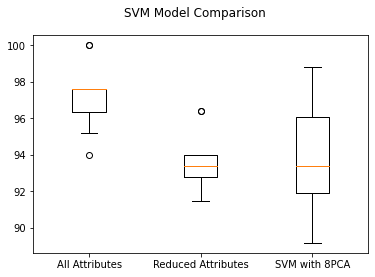

In [166]:
#Cross Validation for SVM with PCA
kfold = KFold(n_splits = 10, random_state = None) # initialising kfold object
scores_svm_pca = cross_val_score(svm_pca, pca_transformed, y, cv = kfold,  scoring='accuracy')*100

print('%s: %f (%f)' %('All Attributes:',scores_svm.mean(), scores_svm.std()))
print('%s: %f (%f)' %('Reduced Attributes:',scores_svmr.mean(), scores_svmr.std()))
print('%s: %f (%f)' %('SVM with 8PCA:',scores_svm_pca.mean(), scores_svm_pca.std()))

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('SVM Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot([scores_svm ,scores_svmr,scores_svm_pca])
ax.set_xticklabels(['All Attributes', 'Reduced Attributes','SVM with 8PCA'])
plt.show()

In [167]:
data = [['All_Attributes (18)', svm.score(scaledX_train,y_train)*100, svm.score(scaledX_test,y_test)*100, scores_svm.mean()],
        ['Reduced attributes(8)', svm_r.score(scaledXr_train,yr_train)*100, svm_r.score(scaledXr_test,yr_test)*100, scores_svmr.mean()],
        ['PCA attributes (8)', svm_pca.score(X_train_pca,y_train_pca)*100, svm_pca.score(X_test_pca,y_test_pca)*100, scores_svm_pca.mean()]
       ]
print ('\033[1m', tabulate(data, headers=["SVM Model", "Training_Score", "Test_Score" , "CrossValidation_Mean_Score"]))

 SVM Model                Training_Score    Test_Score    CrossValidation_Mean_Score
---------------------  ----------------  ------------  ----------------------------
All_Attributes (18)             98.0392       95.7831                       97.2245
Reduced attributes(8)           96.5309       94.5783                       93.6042
PCA attributes (8)              94.5701       95.1807                       93.97


#### Inference:
* The SVM model with PCA with 8 components that explianed 97.9% variance in data has performed well compared to SVM attributes with limited attributes consideration.
* Even the spread of the cv score is better in SVM model with 8 PCA components.

7: 93.970026 (2.848693)
8: 95.296797 (1.973675)
9: 96.021158 (1.788543)
10: 96.141640 (1.684249)
11: 96.863062 (1.722111)
12: 96.863062 (1.722111)
13: 96.983544 (1.887294)
14: 96.983544 (1.887294)
15: 97.224508 (1.793216)
16: 97.224508 (1.793216)
17: 97.224508 (1.793216)
18: 97.224508 (1.793216)


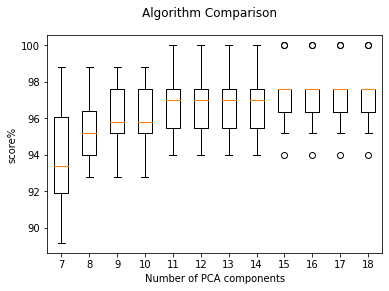

In [175]:
#Evaluating SVM model performance by increasing variance in data
results = []
names = []
for j in np.arange(7,19,1): # for different value of random state
    pca = PCA(n_components = j) 
    pca.fit(scaledX_train)
    pca_transformed =  pca.transform(scaledX)
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_transformed, y, test_size = 0.20, random_state = 1)
    svm_pca = SVC() 
    svm_pca.fit(X_train_pca, y_train_pca) # fitting the model using training dataset
    cv_results = cross_val_score(svm_pca, pca_transformed, y, cv = kfold)*100
    results.append(cv_results)
    names.append(j)
    msg = "%s: %f (%f)" % (j, np.mean(cv_results), cv_results.std())
    print(msg)  

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel("score%")
plt.xlabel("Number of PCA components")
plt.show()

#### Inference:
* From above we can observe the performance improves by increasing PCA variance consideration. 
* However even with less than 18 components we achieve the same performance by considering all components.

## Thank You